In [495]:
import os
import json
from typing import List, Dict

def load_json_files(directory: str) -> List[Dict]:
    """
    Loads all JSON files from the specified directory and returns a list of dictionaries
    containing the data.

    :param directory: The directory containing the JSON files.
    :return: A list of dictionaries, each representing the data from a JSON file.
    """
    data = []
    for filename in os.listdir(directory):
        if filename.endswith(".json"):
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r') as file:
                file_data = json.load(file)
                data.append(file_data)
    return data

# Example usage:
directory_path = "./data/training/"
data = load_json_files(directory_path)


 4  4  8
 6  4  3
 6  3  0



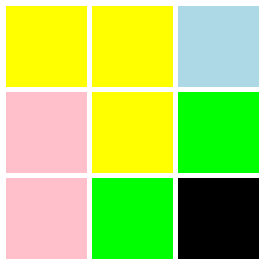

(264, 264)

In [496]:
import numpy as np
from PIL import Image, ImageDraw

# Define the color mapping
color_mapping = {
    0: (0, 0, 0),       # Black
    1: (0, 0, 255),     # Blue
    2: (255, 0, 0),     # Red
    3: (0, 255, 0),     # Green
    4: (255, 255, 0),   # Yellow
    5: (128, 128, 128), # Gray
    6: (255, 192, 203), # Pink
    7: (255, 165, 0),   # Orange
    8: (173, 216, 230), # Light Blue
    9: (128, 0, 0)      # Maroon
}

def grid_to_human_readable(grid: List[List[int]]) -> str:
    """
    Converts a grid to a human-readable, comma-separated format including coordinates.
    
    :param grid: The input grid.
    :return: A string representing the grid in a human-readable format with coordinates.
    """
    # return "\n".join([", ".join(f"({i}, {j}, {cell})" for j, cell in enumerate(row)) for i, row in enumerate(grid)])
    #return "\n".join([", ".join(f"{cell}" for j, cell in enumerate(row)) for i, row in enumerate(grid)])

    # with space digit (maybe it is better because then all digits show as the same token(" N"))
    formatted_output = ""
    for row in grid:
        formatted_output += ' '.join(f' {digit}' for digit in row) + '\n'
    return formatted_output


def grid_to_image(grid: List[List[int]], cell_size: int = 80, separator: int = 6) -> Image.Image:
    """
    Converts a grid to an image using the specified color scheme and returns it as a PIL Image.
    
    :param grid: The input grid.
    :param cell_size: Size of each cell in the grid.
    :param separator: Size of the separator between cells.
    :return: A PIL Image representing the grid.
    """
    rows, cols = len(grid), len(grid[0])
    # Calculate the image size including the separators
    image_width = cols * cell_size + (cols + 1) * separator
    image_height = rows * cell_size + (rows + 1) * separator
    image = Image.new("RGB", (image_width, image_height), "white")
    draw = ImageDraw.Draw(image)

    for i in range(rows):
        for j in range(cols):
            color = color_mapping[grid[i][j]]
            top_left = (j * cell_size + (j + 1) * separator, 
                        i * cell_size + (i + 1) * separator)
            bottom_right = (top_left[0] + cell_size, top_left[1] + cell_size)
            draw.rectangle([top_left, bottom_right], fill=color)

    return image

# Example usage:
example_grid = [
    [4, 4, 8],
    [6, 4, 3],
    [6, 3, 0]
]

# Convert to human-readable format
print(grid_to_human_readable(example_grid))

# Convert to image and save
image = grid_to_image(example_grid)

# Display the image (for Jupyter notebooks)
display(image)
image.size

In [497]:
from PIL import Image, ImageDraw, ImageFont

def resize_image(image: Image.Image, size: tuple = (512, 512)) -> Image.Image:
    """
    Resizes the given image to the specified size.
    
    :param image: The input image.
    :param size: The target size as a tuple (width, height). Default is (512, 512).
    :return: The resized image.
    """
    return image.resize(size, Image.LANCZOS)

def merge_grids_with_labels(input_grid: List[List[int]], output_grid: List[List[int]]) -> Image.Image:
    """
    Merges two grids into a single image with "Input:" and "Output:" labels above the grids.
    
    :param input_grid: The input grid.
    :param output_grid: The output grid.
    :return: A PIL Image with the merged grids and labels.
    """
    # Create images for the input and output grids
    input_image = grid_to_image(input_grid)
    output_image = grid_to_image(output_grid)
    
    # Resize images to 512x512
    input_image = resize_image(input_image)
    output_image = resize_image(output_image)
    
    # Create a new image to combine both grids with labels
    label_height = 50
    separator_width = 20
    combined_width = 2 * 512 + separator_width
    combined_height = 512 + label_height
    
    combined_image = Image.new("RGB", (combined_width, combined_height), "white")
    draw = ImageDraw.Draw(combined_image)
    
    # Load a default font
    font = ImageFont.load_default(32)
    
    # Add labels
    draw.text((512 // 2, 20), "Input:", fill="black", font=font, anchor="mm")
    draw.text((512 + separator_width + 512 // 2, 20), "Output:", fill="black", font=font, anchor="mm")
    
    # Paste the input and output images below the labels
    combined_image.paste(input_image, (0, label_height))
    combined_image.paste(output_image, (512 + separator_width, label_height))
    
    return combined_image

def create_task_grid_image(task_grid: List[List[int]]) -> Image.Image:
    """
    Creates an image from a task grid with the text "Task grid Input:" above it.
    
    :param task_grid: The task grid.
    :return: A PIL Image with the task grid and label.
    """
    # Create an image for the task grid
    task_image = grid_to_image(task_grid)
    
    # Resize image to 512x512
    task_image = resize_image(task_image)
    
    # Create a new image to combine the grid with a label
    label_height = 50
    combined_width = 512
    combined_height = 512 + label_height
    
    combined_image = Image.new("RGB", (combined_width, combined_height), "white")
    draw = ImageDraw.Draw(combined_image)
    
    # Load a default font
    font = ImageFont.load_default(32)
    
    # Add label
    draw.text((combined_width // 2, 20), "Task grid Input:", fill="black", font=font, anchor="mm")
    
    # Paste the task image below the label
    combined_image.paste(task_image, (0, label_height))
    
    return combined_image


In [498]:
def create_merged_images_for_train_pairs(puzzle: Dict) -> List[Image.Image]:
    """
    Creates merged images for each train input/output pair in the puzzle.
    
    :param puzzle: The puzzle containing train input/output pairs.
    :return: A list of PIL Images with the merged input/output grids.
    """
    merged_images = []
    for pair in puzzle["train"]:
        input_grid = pair["input"]
        output_grid = pair["output"]
        merged_image = merge_grids_with_labels(input_grid, output_grid)
        merged_images.append(merged_image)
    return merged_images

def create_human_readable_text_for_train_pairs(puzzle: Dict) -> str:
    """
    Creates a human-readable text string that represents the train input/output pairs.
    
    :param puzzle: The puzzle containing train input/output pairs.
    :return: A human-readable text string.
    """
    text_representation = []
    for i, pair in enumerate(puzzle["train"], start=1):
        input_grid = pair["input"]
        output_grid = pair["output"]
        human_readable_input = grid_to_human_readable(input_grid)
        human_readable_output = grid_to_human_readable(output_grid)
        text_representation.append(
            f"<example>\nExample Grid {i}:\nInput:\n{human_readable_input}\n\nOutput:\n{human_readable_output}\n</example>\n"
        )
    return "\n".join(text_representation)

In [499]:
import base64
import io

def get_messages(puzzle: Dict) -> List[any]:
  train_images = create_merged_images_for_train_pairs(puzzle)

  task_grid = puzzle['test'][0]['input']
  task_image = create_task_grid_image(task_grid)



  human_readable_examples = create_human_readable_text_for_train_pairs(puzzle)

  # I am not sure if giving the color scheme is helpful, or maybe should print with colors and abstract the numbers away completely
  prompt = (
      "<examples>\n"
      f"{human_readable_examples}\n"
      "</examples>\n\n"
      "You are a master logician, capable of picking up complex visual patterns. You can solve any puzzle that comes your way, you are methodical and precise.\n"
      
      "# Problem statement:\n"
      "You are presented with a spacial logic puzzle as well as a series of input-output examples.\n"
      "The same pattern/rule is applied to all the examples, when going form the input grid(on the left) to the output grid(on the right).\n"
      "You have access to the examples in visual form in the images as well as in text form inside <example></example> tags.\n"

      "The color schema for the colors in the grid is as follows:\n"
      "Black: 0\n"
      "Blue: 1\n"
      "Red: 2\n"
      "Green: 3\n"
      "Yellow: 4\n"
      "Gray: 5\n"
      "Pink: 6\n"
      "Orange: 7\n"
      "Light Blue: 8\n"
      "Maroon: 9\n\n"

      # Opus made grids with variable row lengths
      "The shapes of the grid are always rectangular, they are always X by Y, where X and Y are integers greater than 0.\n"

      "Your task is to determine the pattern that governs the transformation from the input to the output.\n"
      "First try to understand the pattern by looking at the examples, then apply the pattern to the task grid input and write the output inside a code block.\n"

      "# Thinking Process:\n"
      "Here are some tips to help you solve the puzzle:\n"
      "- Start by looking for general observations in the examples, then see if you can guess more specific rules.\n"
      # Even with shape instruction, opus can make variable shape grids
      "- Look for input and output shapes. This can suggest what kind of rule is being applied. Is the output shape always the same size? If not then it must be determined by some rule. Remember that they are always rectangular.\n"
      "- Look for the colors/numbers used in the output grids. The colors used are part of the rule. Are there any colors missing? Are there any colors that are always present?\n"
      "- Don't shy away from trying and failing, it's part of the process. If you have a hypothesis, test it on all the examples to see if it holds.\n"
      "- Only your last code block will be evaluated, you can always review it and change it before submitting.\n"

      "# Output Format Instructions:\n"
      # This was a mistake made by gpt4-o but it always does it, TODO: maybe remove for opus
      "- You MUST NOT write out example or task input grids in the output. Only the task output grid(with any amount of attempts) can be written.\n"
      "- You MUST have a thinking process over at least 5 paragraphs in the output. Really think in depth and try and validate multiple hypothesis.\n"
      "- You MUST always review your task output grid before submitting, and make sure it follows the pattern you have identified and applies it correctly to the task input grid. "

      "Really try to look for any flaws in the output.\n"
      "Task Grid:\n"
      "Input:\n"
      f"{grid_to_human_readable(task_grid)}\n"
  )

  
  # create messages
  image_media_type = "image/png"
  
  content = []
  
  for i, image in enumerate(train_images):
      # Convert PIL image to bytes
      img_byte_arr = io.BytesIO()
      image.save(img_byte_arr, format='PNG')
      img_byte_arr = img_byte_arr.getvalue()

      # Encode image bytes to base64
      image_data = base64.b64encode(img_byte_arr).decode("utf-8")

      content.append({"type": "text", "text": f"Example Grid {i + 1} Image:"})
      content.append({
          "type": "image_url",
          "image_url": {
              "url": f"data:{image_media_type};base64,{image_data}",
              "detail": "high"
          }
      })

  # Add task image
  img_byte_arr = io.BytesIO()
  task_image.save(img_byte_arr, format='PNG')
  img_byte_arr = img_byte_arr.getvalue()
  
  # Encode image bytes to base64
  image_data = base64.b64encode(img_byte_arr).decode("utf-8")
  
  # TODO: Not sure if this should be after the prompt or not. Maybe we should add examples xml then task grid image then rest of prompt?
  content.append({"type": "text", "text": "Task Input Grid Image:"})
  content.append({
      "type": "image_url",
      "image_url": {
          "url": f"data:{image_media_type};base64,{image_data}",
          "detail": "high"
      }
  })
  
  # Claude works better with images before text
  content.append({"type": "text", "text": prompt})

  messages = [
      {
          "role": "user",
          "content": content
      }
  ]

  return messages



In [500]:
from my_secrets import OPENAI_API_KEY, ANTHROPIC_API_KEY
from litellm import completion


os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
os.environ["ANTHROPIC_API_KEY"] = ANTHROPIC_API_KEY



In [501]:
def solve_puzzle(puzzle):
  messages = get_messages(puzzle)
  response = completion(
                model="claude-3-opus-20240229",
                messages=messages,
                max_tokens=1024,
                # not sure about optimal temp, probably want some randomness to explore possible solutions
                temperature=0,
                timeout=180,
            )
  
  # always ask to think again
  messages.append(response.choices[0].message)
  messages.append({
    "role": "user",
    "content": [
      {
        "type": "text",
        # With "please think again" can take a correct solution and doubt it and submit a wrong one
        "text": "Please double check. I'm not saying you are either wrong or right, I just want a double check. Please review your hypothesis, review the examples, review the instructions and try to come up with a more detailed explanation of the pattern."
      }
    ]
  })

  response_two = completion(
                model="claude-3-opus-20240229",
                messages=messages,
                max_tokens=1024,
                # not sure about optimal temp, probably want some randomness to explore possible solutions
                temperature=0,
                timeout=180,
            )

  return response, response_two

In [502]:
from parallel_do import parallel_do

def get_grid_size(grid):
  return len(grid), len(grid[0])

def filter_puzzles(puzzles: List[Dict], max_size: int = 10) -> List[Dict]:
  return [puzzle for puzzle in puzzles if all(get_grid_size(pair['output']) <= (max_size, max_size) for pair in puzzle['train'])]

filtered_puzzles = filter_puzzles(data)

# failed to solve 5(intersections), 6(mirroring), 7(pass fail)(masking)
i = 25
puzzles = filtered_puzzles[i:i+4]

In [503]:
responses = parallel_do(puzzles, solve_puzzle)

In [504]:
import re
def extract_last_code_block(text: str) -> str:
    """
    Extracts only the code from the last code block in the given text.

    :param text: The input text.
    :return: The last code block's content in the text.
    """
    code_blocks = re.findall(r"```(?:\w*)\n(.*?)```", text, re.DOTALL)
    if code_blocks:
        return code_blocks[-1].strip()
    return ""

In [505]:
from typing import List, Tuple, Dict

def extract_text(response_tuple: Tuple) -> str:
    return response_tuple[1].choices[0].message.content

def extract_proposed_grid(text: str) -> str:
    return extract_last_code_block(text)

def get_solution(puzzle: Dict) -> str:
    return grid_to_human_readable(puzzle['test'][0]['output'])

def evaluate_response(proposed_grid: str, solution: str) -> bool:
    # remove any empty lines
    proposed_grid = proposed_grid.strip()
    solution = solution.strip()
    # remove whitespace for each line
    proposed_grid = "\n".join([line.strip() for line in proposed_grid.split("\n")])
    solution = "\n".join([line.strip() for line in solution.split("\n")])
    return proposed_grid == solution

def evaluate_puzzles(responses: List[Tuple], puzzles: List[Dict], attempt: int) -> List[bool]:
    puzzles_eval = []
    for response_tuple, puzzle in zip(responses, puzzles):
        text = response_tuple[attempt].choices[0].message.content
        proposed_grid = extract_proposed_grid(text)
        solution = get_solution(puzzle)
        is_correct = evaluate_response(proposed_grid, solution)
        puzzles_eval.append(is_correct)
    return puzzles_eval

puzzles_eval_first_attempt = evaluate_puzzles(responses, puzzles, attempt=0)
puzzles_eval_second_attempt = evaluate_puzzles(responses, puzzles, attempt=1)


In [506]:
print(f"Accuracy on first attempt: {sum(puzzles_eval_first_attempt) / len(puzzles_eval_first_attempt) * 100:.2f}%")
print(f"Accuracy on second attempt: {sum(puzzles_eval_second_attempt) / len(puzzles_eval_second_attempt) * 100:.2f}%")


Accuracy on first attempt: 0.00%
Accuracy on second attempt: 0.00%


# Debug zone

In [507]:
response_index = 0
response_tuple = responses[response_index]

# 0 is the first response, 1 is the second response (after asking to think again) ...
tuple_index = 0
response = response_tuple[tuple_index]
puzzle = puzzles[response_index]
print(response.choices[0].message.content)

Here is my thinking process and solution for this puzzle:

Observations:
1. The output grid is always a 3x3 square, regardless of the size of the input grid. This suggests the rule is extracting or summarizing information from the input into a fixed size output.

2. The output only contains the colors blue (1), red (2), yellow (4), and light blue (8). Black (0) is never present in the output despite being the most common color in the input. This implies the rule is selecting for specific colors and ignoring others.

3. The placement of colors in the output seems to correspond to vertical "stripes" or "bands" in the input. For example, a vertical stripe of yellow (4) in the middle of the input results in a yellow (4) in the middle of the output.

4. When there are multiple colors in a vertical stripe, the output seems to take the color that is not red (2). Red acts as a "background" color.

Hypothesis:
I believe the rule is as follows:
- Divide the input grid into 3 equal width vertical

In [508]:
text = response.choices[0].message.content
proposed_grid = extract_last_code_block(text)
# remove any newlines
proposed_grid = proposed_grid.strip()
# remove trailling whitespace for each line
proposed_grid = "\n".join([line.strip() for line in proposed_grid.split("\n")])
print(f"Proposed grid:\n{proposed_grid}")

solution = grid_to_human_readable(puzzle['test'][0]['output']).strip()
# remove any newlines
solution = solution.strip()
# remove trailling whitespace for each line
solution = "\n".join([line.strip() for line in solution.split("\n")])
print(f"Solution grid:\n{solution}")

is_correct = proposed_grid == solution

print(f"Is correct: {is_correct}")

Proposed grid:
1 8 4
1 8 4
1 8 4
Solution grid:
1  0  4
0  0  0
8  8  8
Is correct: False


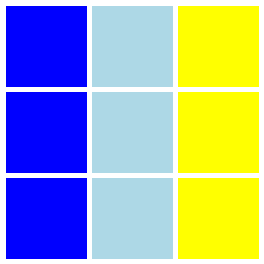

In [509]:
proposed_grid_list = [[int(cell) for cell in row.split()] for row in proposed_grid.split("\n")]
proposed_grid_image = grid_to_image(proposed_grid_list)
display(proposed_grid_image)

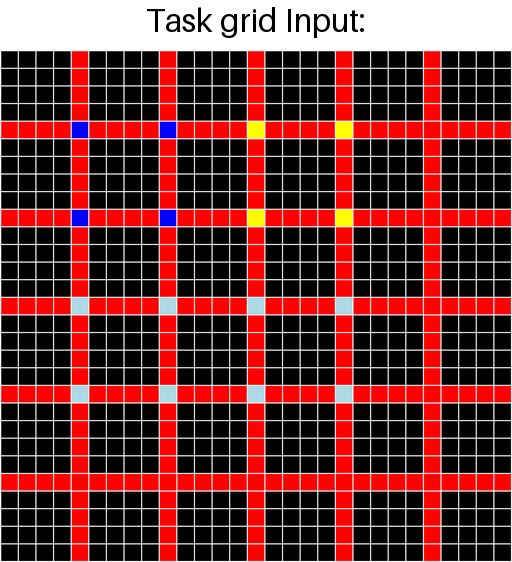

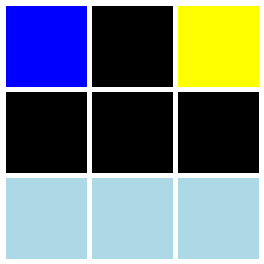

In [510]:
task_input_image = create_task_grid_image(puzzle['test'][0]['input'])
display(task_input_image)
task_output_image = grid_to_image(puzzle['test'][0]['output'])
display(task_output_image)